# Описание проекта

Проводится анализ для компании «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [68]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [69]:
data = pd.read_csv('/datasets/games.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<p style="color:green">Данные загруженыa и изучены, отлично</p>

## Шаг 2. Подготовьте данные

In [70]:
# Приведем имена столбцов к нижнему регистру
data.columns = (
    ['name', 
     'platform', 
     'year_of_release', 
     'genre', 
     'na_sales', 
     'eu_sales', 
     'jp_sales', 
     'other_sales', 
     'critic_score', 
     'user_score', 
     'rating']
)

In [71]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [72]:
# Преобразуем данные к нужному типу
# Замечаем, что рейтинги в колонке user_score хранятся в виде строк, приведем их к float64
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Мы видим пропуски в следующих колонках:
* <code>name</code>: 2 пропуска
* <code>year_of_release</code>
* <code>genre</code>: 2 пропуска
* <code>critic_score</code>
* <code>user_score</code>
* <code>rating</code>

Нам известно, что данные были взяты из открытых источников (возможно, парсингом каких-то обзорных сайтов). Вероятно, из-за способа получения информации часть данных была недополучена (особенно это касается колонок с оценками и рейтингом).

Очевидно, что большинство этих колонок мы не сможем заполнить автоматом. Заполнять "по среднему" рейтинги или оценки некорректно, ну а угадать имя или жанр игры мы тоже не сможем. 

Исключение составляет колонка <code>year_of_release</code> - ее мы проверим и обработаем позднее.

Дополнительно обращаю внимание. В описании к проекту сказано: <i>"Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать"</i>. Однако при проверке уникальных значений в колонке <code>rating</code> значение 'tbd' не обнаружил. Но на сайте www.esrb.org упоминается рейтинг 'rp' (rating pending - рейтинг в ожидании). Принял решение для строк с рейтингом 'rp' заменить рейтинг на 'nan'.

In [73]:
print(data['rating'].unique())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


In [74]:
data.loc[data['rating'] == 'RP', 'rating'] = np.nan

Дополнительно проверим какие значения хранятся в колонках <code>critic_score</code> и <code>user_score</code> на предмет аномалий.

In [75]:
print(np.sort(data['critic_score'].unique()))
print(np.sort(data['user_score'].unique()))

[13. 17. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.
 89. 90. 91. 92. 93. 94. 95. 96. 97. 98. nan]
[0.  0.2 0.3 0.5 0.6 0.7 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.
 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8
 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6
 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4
 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9 9.  9.1 9.2
 9.3 9.4 9.5 9.6 9.7 nan]


Аномалий не выявлено. Идем дальше.

### Колонка Год выпуска

In [76]:
data.query('year_of_release.isnull()').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Замечаем, что в названиях игр может присутствовать год. Логично предположить, что Madden NFL 2004 вышла где-то в 2004 году.

In [77]:
# Реализуем функцию, получающую год выпуска из наименования игры
# Если год получить не удалось, то функция вернет nan
min_year = int(data['year_of_release'].min())
max_year = int(data['year_of_release'].max())

m = Mystem()
def get_year_from_name(name):
    if (pd.isnull(name)): 
        return np.nan
    result = np.nan
    lemmas = m.lemmatize(name)
    for i in range(0, len(lemmas)):
        try:
            if (min_year < int(lemmas[i]) < max_year):
                result = int(lemmas[i])
                break
        except: ()
    return result

def get_year_for_row(row):
    if (pd.notnull(row['year_of_release'])):
        return row['year_of_release']
    else:
        return get_year_from_name(row['name'])
    
# Проверим на нескольких примерах
print(get_year_from_name('Madden NFL 2004'))
print(get_year_from_name('Madden NFL (2004)'))

2004
2004


In [78]:
print('Год выпуска не заполнен в строках:', data.query('year_of_release.isnull()').shape[0])

Год выпуска не заполнен в строках: 269


In [79]:
data['year_of_release'] = data.apply(get_year_for_row, axis=1)
print('Год выпуска не заполнен в строках:', data.query('year_of_release.isnull()').shape[0])

Год выпуска не заполнен в строках: 252


Удалось дозаполнить год в 17 строках.

In [80]:
data.query('year_of_release.isnull()').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.0,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.0,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,NaN,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.0,0.21,78.0,6.6,E10+


Для удобства посчитаем суммарные продажи во всех регионах

In [81]:
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Шаг 3. Исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

1980
2016


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f076268e550>]],
      dtype=object)

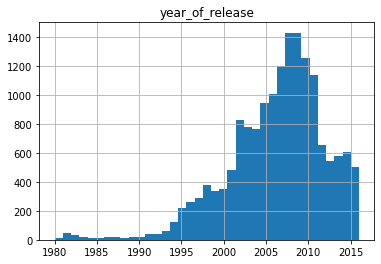

In [82]:
print(min_year)
print(max_year)
data.hist('year_of_release', range=(min_year, max_year), bins=(max_year - min_year + 1))

In [83]:
data.query('year_of_release >= 2006 and year_of_release <= 2016').groupby('year_of_release')['year_of_release'].count()

year_of_release
2006.0    1008
2007.0    1198
2008.0    1429
2009.0    1427
2010.0    1255
2011.0    1137
2012.0     653
2013.0     545
2014.0     581
2015.0     606
2016.0     502
Name: year_of_release, dtype: int64

По гистограмме можно сделать выводы, что: с 80-х годов игровая индустрия развивается лавинообразно. Пик количества выпущенных игр в 2007-2008 году, затем произошел спад. При чем между 2011 и 2012 годом наблюдается практически 2-кратный спад (1137 - в 2011 и 653 - в 2012). Возможная причина - появление новых требовательных платформ, игры стали более сложными, масштабными - поэтому игр выпускается меньше.

В итоге при анализе данных мы можем ограничиться выборкой за несколько последних лет. <b>Сколько именно лет - определим в ходе дальнейшего анализа.</b>

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [84]:
data_sales = data.pivot_table(index=['platform', 'year_of_release'], values='sales', aggfunc='sum')
data_sales = data_sales.reset_index()
data_sales

,platform,year_of_release,sales
0,2600,1980.0,11.38
1,2600,1981.0,35.68
2,2600,1982.0,28.88
3,2600,1983.0,5.84
4,2600,1984.0,0.27
...,...,...,...
233,XB,2008.0,0.18
234,XOne,2013.0,18.96
235,XOne,2014.0,54.07
236,XOne,2015.0,60.14


In [85]:
data_platform_life = data_sales.pivot_table(
    index='platform', 
    values=['year_of_release', 'sales'], 
    aggfunc={'year_of_release': ['min', 'max'], 'sales': 'sum'}
)
data_platform_life = data_platform_life.reset_index()
data_platform_life.columns = ['platform', 'sales', 'death_year', 'birth_year']

# Для удобства переставлю колонки 'last_year', 'first_year' местами
data_platform_life = data_platform_life.loc[:, ['platform', 'sales', 'birth_year', 'death_year']]

# Расчитаем возраст жизни платформы
data_platform_life['age'] = data_platform_life['death_year'] - data_platform_life['birth_year']

# Если 'last_year' = 2016, это не значит, что платформа умерла
data_platform_life.loc[data_platform_life['death_year'] == 2016, 'death_year'] = np.nan
data_platform_life['is_alive'] = pd.isnull(data_platform_life['death_year'])

data_platform_life

,platform,sales,birth_year,death_year,age,is_alive
0,2600,86.48,1980.0,1989.0,9.0,False
1,3DO,0.10,1994.0,1995.0,1.0,False
2,3DS,257.81,2011.0,NaN,5.0,True
3,DC,15.95,1998.0,2008.0,10.0,False
4,DS,802.79,1985.0,2013.0,28.0,False
5,GB,254.43,1988.0,2001.0,13.0,False
6,GBA,312.88,2000.0,2007.0,7.0,False
7,GC,197.03,2001.0,2007.0,6.0,False
8,GEN,30.77,1990.0,1994.0,4.0,False
9,GG,0.04,1992.0,1992.0,0.0,False


In [86]:
# Для уже "умерших" платформ можем определить средний срок жизни
data_platform_life.query('death_year.notnull()')['age'].mean()

7.0

In [87]:
# Посмотрим на платформы с наибольшими суммарными продажами
top_platforms = data_sales.groupby('platform')['sales'].sum().sort_values(ascending=False).head(10)
top_platforms

platform
PS2     1247.28
X360     961.30
PS3      931.34
Wii      891.18
DS       802.79
PS       727.58
PS4      314.14
GBA      312.88
PSP      290.34
3DS      257.81
Name: sales, dtype: float64

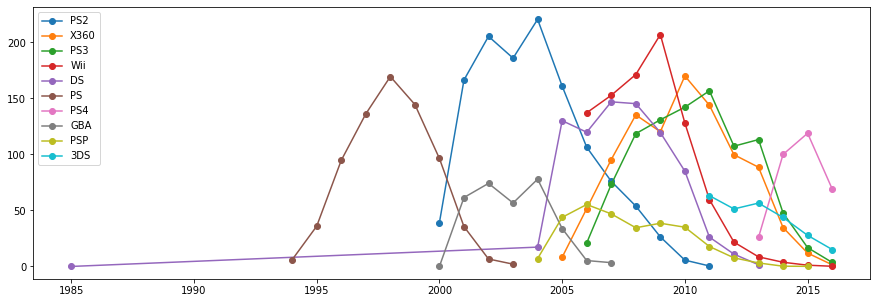

In [88]:
# и постром распределение этих продаж по годам в виде графика
plt.figure(figsize=(15, 5)) 

for platform in top_platforms.index:
    plt.plot(
        data_sales.query('platform == @platform')['year_of_release'],
        data_sales.query('platform == @platform')['sales'],
        'o-',
        label=platform
    )

plt.legend()
plt.show()

<p style="color:green">Визуализации ты отлично освоил, молодец!</p>

Тут мы воочию видим процесс появления и неизбежного умирания платформ, пусть и самых прибыльных. PS4 неизбежно вымрет, также как и ее предшественники: PS2 и PS3.

Также график показал вероятную ошибку в данных. Действительно у платформы DS какой-то странных хвост с 1985 года, потом расцвет где-то в конце 2000 и спад после 2010 года. Это повод отправить баг-репорт ответственному за выгрузку для дополнительной проверки.

In [89]:
data.query('platform == "DS" and year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Пришло время отсечь ненужные данные.

Для начала проанализируем продажи "живых" платформ по годам. PC - "вечно живая" платформа, рассмотрим ее только за последние 10 лет.

In [90]:
# Продажи "живых" платформ
alive_platforms = data_platform_life.query('is_alive')['platform'].unique()
data_sales.query('(platform in (@alive_platforms) and platform != "PC") or (platform == "PC" and year_of_release >= 2006 and year_of_release <= 2016)').pivot_table(
    index='platform',
    values='sales',
    columns='year_of_release',
    aggfunc='sum',
    fill_value=''
)

year_of_release,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
platform,,,,,,,,,,,,
3DS,,,,,,,63.2,51.36,56.57,43.76,27.78,15.14
PC,,2.85,9.28,12.42,16.91,24.28,35.03,23.22,12.73,13.28,8.52,5.25
PS3,,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,,,,,,,,,25.99,100.00,118.90,69.25
PSV,,,,,,,4.63,16.19,10.59,11.90,6.25,4.25
Wii,,137.15,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
WiiU,,,,,,,,17.56,21.65,22.03,16.35,4.60
X360,8.25,51.62,95.42,135.26,120.29,170.03,143.89,99.74,88.58,34.74,11.96,1.52
XOne,,,,,,,,,18.96,54.07,60.14,26.15


Итак:
* "живые" старички (PS3, Wii, X360) показывают спад продаж, который очевидно продолжится и далее
* замечаем, что другие платформы родились в 2011-2012 году
* помним про 2012 год, как год резкого уменьшения количества выпущенных игр (см. выше). Тогда мы предоложили, что где-то в это время вышли новые более требовательные платформы, и процесс выпуска игр стал более долгим и требовательным

В итоге по совокупности факторов принимаю решение <b>в качестве актуальных данных взять данные с 2012 года</b>.

In [91]:
data_actual = data.query('year_of_release >= 2012')
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2887 entries, 16 to 16714
Data columns (total 12 columns):
name               2887 non-null object
platform           2887 non-null object
year_of_release    2887 non-null float64
genre              2887 non-null object
na_sales           2887 non-null float64
eu_sales           2887 non-null float64
jp_sales           2887 non-null float64
other_sales        2887 non-null float64
critic_score       1313 non-null float64
user_score         1532 non-null float64
rating             1612 non-null object
sales              2887 non-null float64
dtypes: float64(8), object(4)
memory usage: 293.2+ KB


### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ

Вернемся к полученной выше таблице о продажах по "живым" платформам. По условиям задачи нам известно, что <i>"сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й"</i> - по этому можно предположить, что данные за 2016 год не полные. Поэтому перспективные платформы определим так:
* рост в 2015 году по сравнению с 2014 годом
* значительная доля в продажах

Даже без построения дополнительных срезов мы видим, что сейчас <b>к перспективным и потенциально прибыльным можно отнести XOne и PS4</b>.

### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

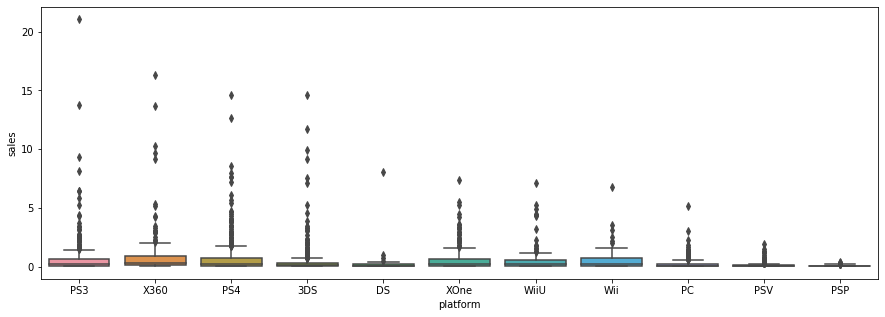

In [92]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='platform', y='sales', data=data_actual)
plt.show()

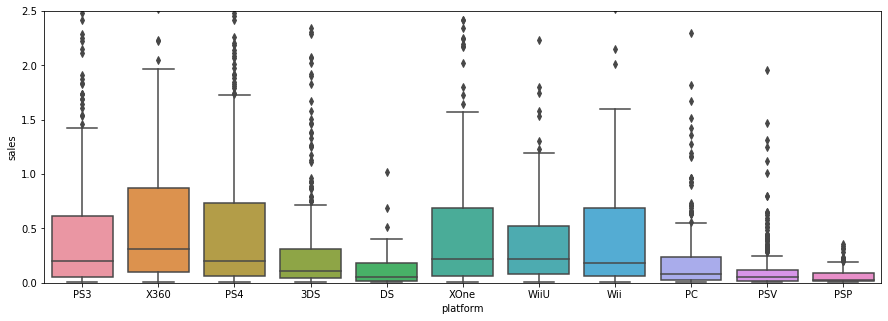

In [93]:
plt.figure(figsize=(15, 5))
plt.ylim(0, 2.5)
sns.boxplot(x='platform', y="sales", data=data_actual)
plt.show()

In [94]:
print(data_actual.groupby('platform')['sales'].mean().sort_values(ascending=False))
print(data_actual.groupby('platform')['sales'].median().sort_values(ascending=False))

platform
X360    0.810068
PS4     0.801378
Wii     0.655000
XOne    0.645020
PS3     0.585781
WiiU    0.559116
3DS     0.491439
DS      0.404839
PC      0.250996
PSV     0.119659
PSP     0.064682
Name: sales, dtype: float64
platform
X360    0.31
XOne    0.22
WiiU    0.22
PS4     0.20
PS3     0.20
Wii     0.18
3DS     0.11
PC      0.08
PSV     0.05
DS      0.05
PSP     0.03
Name: sales, dtype: float64


По "ящикам" и средним значениям продаж видим:
* явный лидер продаж X360
* далее графики (и разброс продаж) 3-х платформ примерно совпадают - это PS4, XOne, Wii
* WiiU меньше чем у Wii, хотя WiiU - является преемником Wii. Это несложно объяснить тем, что Wii прожила почти в 2 раза дольше и была популярна в свое время, WiiU, видимо, зашла игрокам хуже. За счет своего удачного старта Wii и обогнала WiiU.
* средние продажи больше у самых новых платформ X360, PS4 (это объяснимо - с повлением новых консолей цены на игры для старых консолей обычно падают)

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Для примера возьмем X360

0.3605734888507336


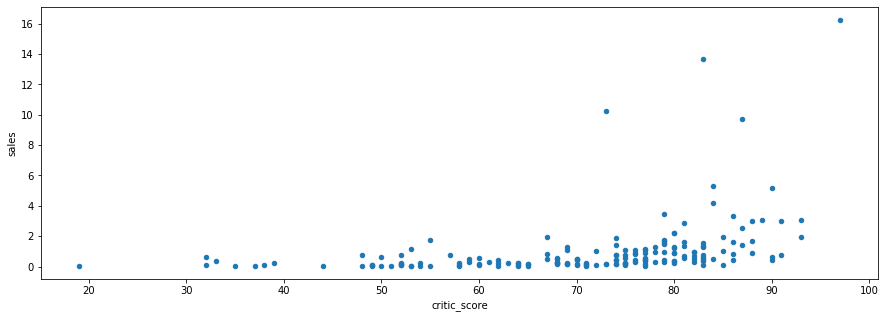

In [95]:
print(data_actual.query('platform == "X360"')['critic_score'].corr(data_actual['sales']))
data_actual.query('platform == "X360"').plot(x='critic_score', y='sales', kind='scatter', figsize=(15,5))

0.006163978646213326


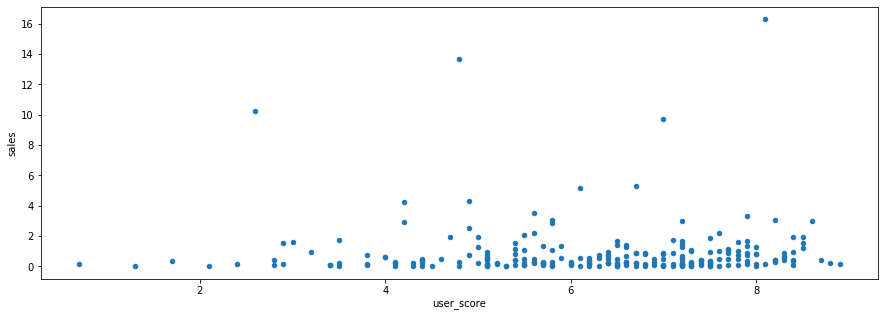

In [96]:
print(data_actual.query('platform == "X360"')['user_score'].corr(data_actual['sales']))
data_actual.query('platform == "X360"').plot(x='user_score', y='sales', kind='scatter', figsize=(15,5))

Интересный результат: корреляция между отзывами игроков и продажам практически нулевая! Народная любовь - предмет темный. Проще прогнозировать продажи исходя из отзывов критиков (корреляция не 1, но хотя бы 0,36).

Проверим зависимости продаж от отзывов для других платформ.

In [97]:
data_actual.groupby('platform')['user_score', 'critic_score'].corr(data_actual['sales'])

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,user_score,critic_score
platform,,
3DS,0.197583,0.320803
DS,0.882709,NaN
PC,-0.120595,0.237239
PS3,-0.005144,0.331497
PS4,-0.031957,0.406568
PSP,-0.802302,NaN
PSV,-0.004339,0.094488
Wii,0.296197,-0.424341
WiiU,0.400219,0.348380


Кто в лес, кто по дрова! Оценка может уйти и в минус (-0,8 для PSP) и в плюс (0,88 для DS).

In [98]:
data_actual.query('platform in ("X360", "PS4", "WiiU")').groupby(['platform', 'year_of_release'])['user_score', 'critic_score'].corr(data_actual['sales'])

user_score  critic_score
platform year_of_release                          
PS4      2013.0             0.531285      0.617379
         2014.0             0.031691      0.492459
         2015.0            -0.002308      0.412342
         2016.0            -0.122461      0.375695
WiiU     2012.0             0.389131      0.292228
         2013.0             0.453596      0.418334
         2014.0             0.477789      0.446193
         2015.0             0.400175      0.332829
         2016.0             0.437630      0.486490
X360     2012.0             0.004433      0.377918
         2013.0            -0.026248      0.342047
         2014.0            -0.175766      0.525723
         2015.0            -0.432389           NaN
         2016.0            -0.399000           NaN

Еще один пример. Для платформ PS4 и X360 коэффициент корреляции продаж и отзывов сказывается в низ (от положительного к отрицательному значению) с годами. А для WiiU коэффициент достаточно стабилен и сильно не меняется с годами.

Очевидно, отзывы и продажи вещи связанные, но вот <b>на итоговые продажи влияют не только положительные или отрицательные отзывы.</b>

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [99]:
data_actual.groupby('genre')['sales'].mean().sort_values(ascending=False)

genre
Shooter         1.296723
Platform        0.717647
Sports          0.675634
Role-Playing    0.521081
Racing          0.465217
Misc            0.442917
Simulation      0.439000
Action          0.427781
Fighting        0.408165
Strategy        0.187887
Puzzle          0.174643
Adventure       0.097450
Name: sales, dtype: float64

* лидер среди продаж шутеры
* хуже всего продаются игр в жанре Adventure

## Шаг 4. Составьте портрет пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [100]:
area_sales_list = ['eu_sales', 'na_sales', 'jp_sales']

### По платформам

In [101]:
# общая таблица по платформам
data_actual.pivot_table(index='platform', values=area_sales_list, aggfunc='sum', fill_value='')

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,38.01,0.00,19.18
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


In [102]:
# топ-5 платформ для каждого региона
for value in area_sales_list:
    print(data_actual.pivot_table(
            index='platform', 
            values=value, 
            aggfunc='sum').sort_values(by=value, ascending=False).head(5))
    print()

          eu_sales
platform          
PS4         141.09
PS3         106.86
X360         74.52
XOne         51.59
3DS          42.64

          na_sales
platform          
X360        140.05
PS4         108.74
PS3         103.38
XOne         93.12
3DS          55.31

          jp_sales
platform          
3DS          87.79
PS3          35.29
PSV          21.04
PS4          15.96
WiiU         13.01



* Европейский и американский рынки очень похожи. Единственное заметное отличие - в NA заметно больше продаж X360 и XOne, аналогично PS4 популярнее в Европе. Возможно дело в агрессивной маркетинговой политике производителей в соответствующих регионах.
* В Японии заметно популярны PSP и 3DS - портативные платформы

### По жанрам

In [103]:
# общая таблица по жанрам
data_actual.pivot_table(index='genre', values=area_sales_list, aggfunc='sum', fill_value='')

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.59,52.80,177.90
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.40,2.14,1.13
Racing,27.29,2.50,17.22
Role-Playing,48.53,65.44,64.00
Shooter,113.47,9.23,144.77


In [104]:
# топ-5 платформ для каждого региона
for value in area_sales_list:
    print(data_actual.pivot_table(
            index='genre', 
            values=value, 
            aggfunc='sum').sort_values(by=value, ascending=False).head(5))
    print()

              eu_sales
genre                 
Action          159.59
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29

              na_sales
genre                 
Action          177.90
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19

              jp_sales
genre                 
Role-Playing     65.44
Action           52.80
Misc             12.86
Simulation       10.41
Fighting          9.44



* EU и NA очень практически идентичны по предпочитаемым жанрам
* Япония - на своей волне. Role-Playing - единственный жанр продаваемый в Японии лучше чем в Европе и Америке
* Action - жанр игр, любимый во всех регионах

### Влияние рейтинга ESRB на продажи

In [105]:
# общая таблица по рейтингам
data_actual.pivot_table(index='rating', values=area_sales_list, aggfunc='sum', fill_value='')

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,194.21,21.20,231.63
T,52.96,26.02,66.02


* E - everyone
* E10+ - everyone 10+
* T - 13+
* M - 17+

* Заметно, что в Европе и Америке по продажам популярнее контент 17+
* Японцы более "инфантильны", предпочитая ненавязчивые E и T

## Шаг 5. Проверка гипотез

In [106]:
alpha = 0.05

### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Имеем гипотезу о равенстве средних двух генеральных совокупностей. Нулевая гипотеза: "Средние пользовательские рейтинги платформ Xbox One и PC совпадают"

In [107]:
results = st.ttest_ind(
    data_actual.query('platform == "XOne" and user_score.notnull()')['user_score'],
    data_actual.query('platform == "PC" and user_score.notnull()')['user_score'],
    equal_var=False
)

print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5926118514134862
Не получилось отвергнуть нулевую гипотезу


Мы не можем отвергнуть нулевую гипотезу, делаем вывод, что скорее всего "Средние пользовательские рейтинги платформ Xbox One и PC совпадают"

### Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные

Имеем гипотезу о равенстве средних двух генеральных совокупностей. Нулевая гипотеза: "Средние пользовательские рейтинги жанров Action и Sports совпадают"

In [108]:
results = st.ttest_ind(
    data_actual.query('genre == "Action" and user_score.notnull()')['user_score'],
    data_actual.query('genre == "Sports" and user_score.notnull()')['user_score'],
    equal_var=False
)

print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

3.551295319559386e-20
Отвергаем нулевую гипотезу


Мы можем отвергнуть нулевую гипотезу, делаем вывод, что скорее всего "Средние пользовательские рейтинги жанров Action и Sports различаются"

## Общий вывод

Был проведен анализ для компании "Стримчик" для прогнозирования рекламных кампаний на 2017 год. Для анализа были предоставлены данные о продажах игр в разных регионах с 1980 года по 2016 год. В результате был проведен дополнительный анализ, позволивший отсечь лишние данные: в итоге по ряду факторов было принято решение использовать данные с 2012 года.

Для 2017 года наиболее прибыльными и потенциальными платформами считаю самые современные - XOne и PS4 (обе появились в 2013 году). Обращает внимание, что XOne более популярна в NA, а PS4 - в Европе. Также необходимо обратить внимание, на заметную популярность портативных платформ (например, 3DS) в Японии.

Была исследована зависимость продаж игр от отзывов критиков и игроков. Сделанные вывод: отзывы и продажи вещи связанные, но вот на итоговые продажи влияют не только положительные или отрицательные отзывы. Впрочем, заметно, что именно отзывы критиков коррелируют с итоговыми продажами (коэффициент корреляции балансирует где-то на уровне 0,3-0,4, тогда как для отзывов игроков КК может уйти и в минус).

Любовь к конкретным жанрам в Европе и Америке - практически совпадает (ТОП-3 - Action, Shooter, Sports), в Японии рекламные кампании надо ориентировать на другие жанры (Role-Playing, Action, Misc). Также в ходе исследования заметили, что в Японии более популярны "детские" игры (категории E и T), в EU и NA покупатели больше денег тратят на игры 17+ (рейтинг M).

Дополнительно были проверены 2 гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - результат: ДА, это так
* Средние пользовательские рейтинги жанров Action и Sports разные - результат: Да, это так